In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm_notebook
import plotly.figure_factory as ff

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [64]:
data=pd.read_csv('water_potability.csv')
data.head()

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0

### EDA

- ph-> pH of water
- Hardness-> Capacity of water to precipitate soap in mg/L
- Solids-> Total dissolved solids in ppm
- Chloramines-> Amount of Chloramines in ppm
- Sulfate-> Amount of Sulfates dissolved in mg/L
- Conductivity-> Electrical conductivity of water in μS/cm
- Organic_carbon-> Amount of organic carbon in ppm
- Trihalomethanes-> Amount of Trihalomethanes in μg/L
- Turbidity-> Measure of light emiting property of water in NTU (Nephelometric Turbidity Units)
- Potability-> Indicates if water is safe for human consumption


In [65]:
data.describe()

ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.594320    32.879761   8768.570828     1.583085    41.416840   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.093092   176.850538  15666.690297     6.127421   307.699498   
50%       7.036752   196.967627  20927.833607     7.130299   333.073546   
75%       8.062066   216.667456  27332.762127     8.114887   359.950170   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3114.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.390110  
std       80.824064        3.308162        16.175008     0.780382     0.487849  
min      181.483754        2.200000         0.738000     1.450000     0.000000  
25%      365.734414       12.065801        55.844536     3.439711     0.000000  
50%      421.884968       14.218338        66.622485     3.955028     0.000000  
75%      481.792304       16.557652        77.337473     4.500320     1.000000  
max      753.342620       28.300000       124.000000     6.739000     1.000000

In [66]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [67]:
print('There are {} data points and {} features in the data'.format(data.shape[0],data.shape[1]))


There are 3276 data points and 10 features in the data


### Null Values

<AxesSubplot:>

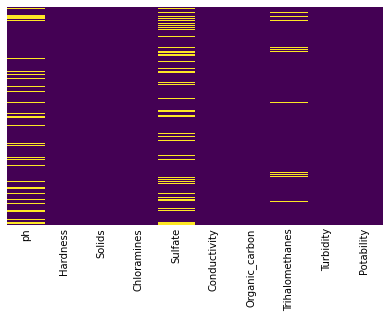

In [68]:
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')


In [69]:
for i in data.columns:
    if data[i].isnull().sum()>0:
        print("There are {} null values in {} column".format(data[i].isnull().sum(),i))

There are 491 null values in ph column
There are 781 null values in Sulfate column
There are 162 null values in Trihalomethanes column


### Handling Null Values


#### PH


In [70]:
data['ph'].describe()


count    2785.000000
mean        7.080795
std         1.594320
min         0.000000
25%         6.093092
50%         7.036752
75%         8.062066
max        14.000000
Name: ph, dtype: float64

Filling the missing values by mean

In [71]:
data['ph_mean']=data['ph'].fillna(data['ph'].mean())
data['ph_mean'].isnull().sum()


0

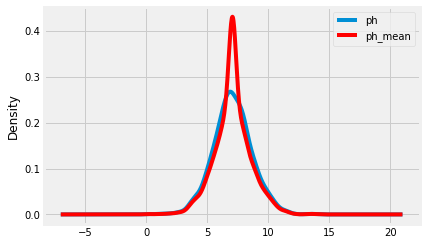

In [72]:
fig = plt.figure()
ax = fig.add_subplot(111)
data['ph'].plot(kind='kde', ax=ax)
data.ph_mean.plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

The distribution is not uniform

#### Filling the data with random values

In [73]:
def impute_nan(df,variable):
    df[variable+"_random"]=df[variable]
    ##It will have the random sample to fill the na
    random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
    ##pandas need to have same index in order to merge the dataset
    random_sample.index=df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable+'_random']=random_sample

In [74]:
impute_nan(data,"ph")

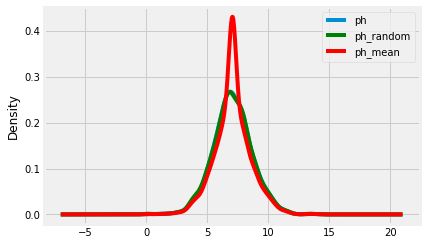

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111)
data['ph'].plot(kind='kde', ax=ax)
data.ph_random.plot(kind='kde', ax=ax, color='green')
data.ph_mean.plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

Uniform distribution with random initialization

In [76]:
impute_nan(data,"Sulfate")

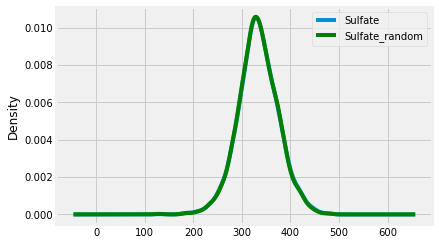

In [77]:
fig = plt.figure()
ax = fig.add_subplot(111)
data['Sulfate'].plot(kind='kde', ax=ax)
data["Sulfate_random"].plot(kind='kde', ax=ax, color='green')
#data.ph_mean.plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

In [78]:
impute_nan(data,"Trihalomethanes")

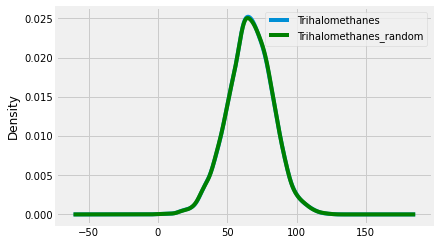

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111)
data['Trihalomethanes'].plot(kind='kde', ax=ax)
data.Trihalomethanes_random.plot(kind='kde', ax=ax, color='green')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

In [80]:
data=data.drop(['ph','Sulfate','Trihalomethanes','ph_mean'],axis=1)

In [81]:
data.isnull().sum()

Hardness                  0
Solids                    0
Chloramines               0
Conductivity              0
Organic_carbon            0
Turbidity                 0
Potability                0
ph_random                 0
Sulfate_random            0
Trihalomethanes_random    0
dtype: int64

### Check for Correlation

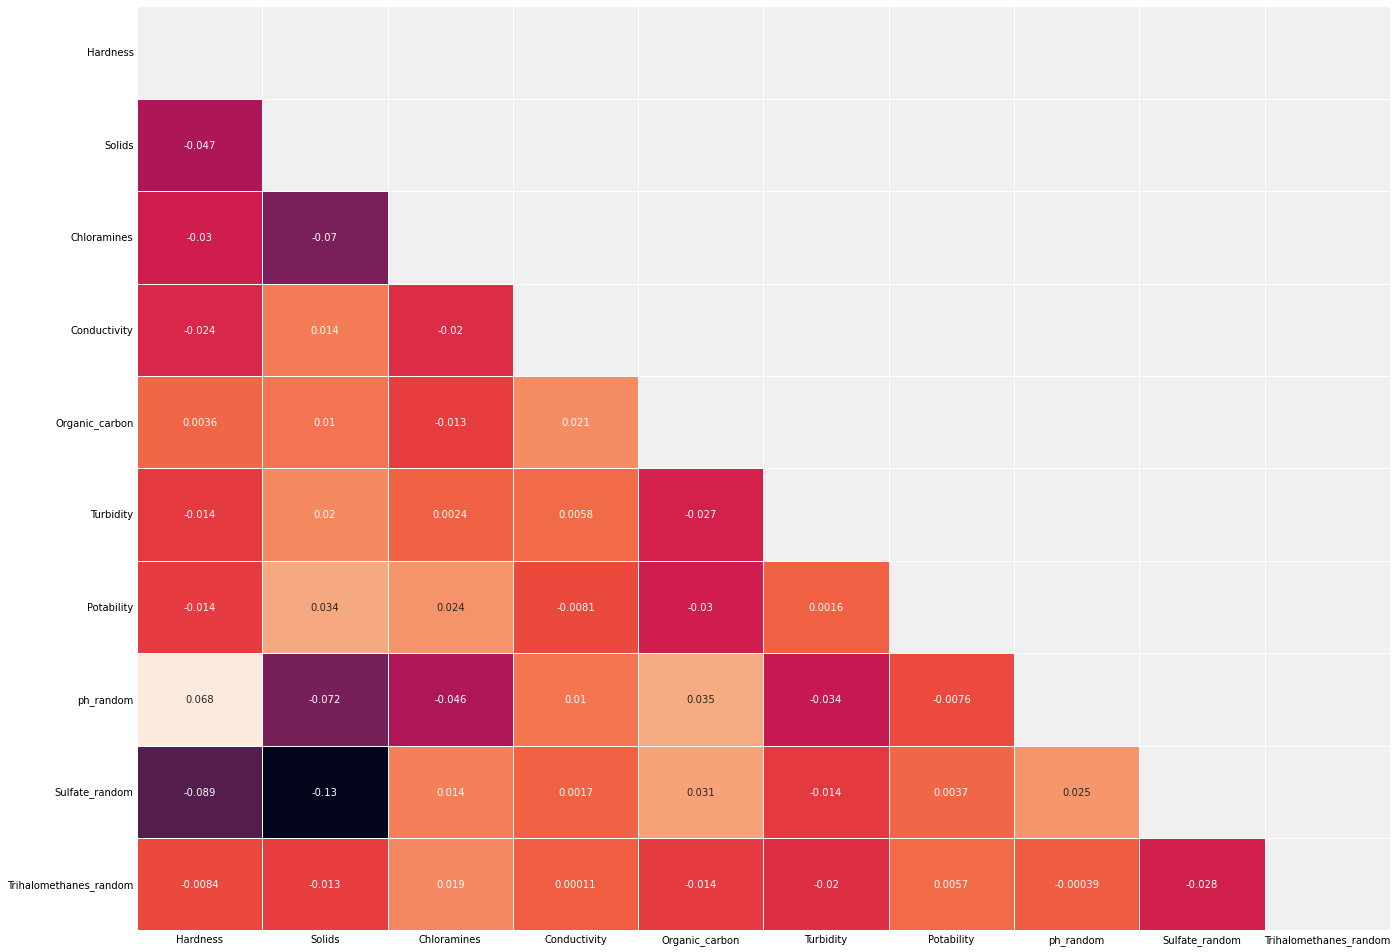

In [82]:
plt.figure(figsize=(20, 17))
matrix = np.triu(data.corr())
sns.heatmap(data.corr(), annot=True,linewidth=.8, mask=matrix, cmap="rocket",cbar=False);

There are no correlated columns present in the data

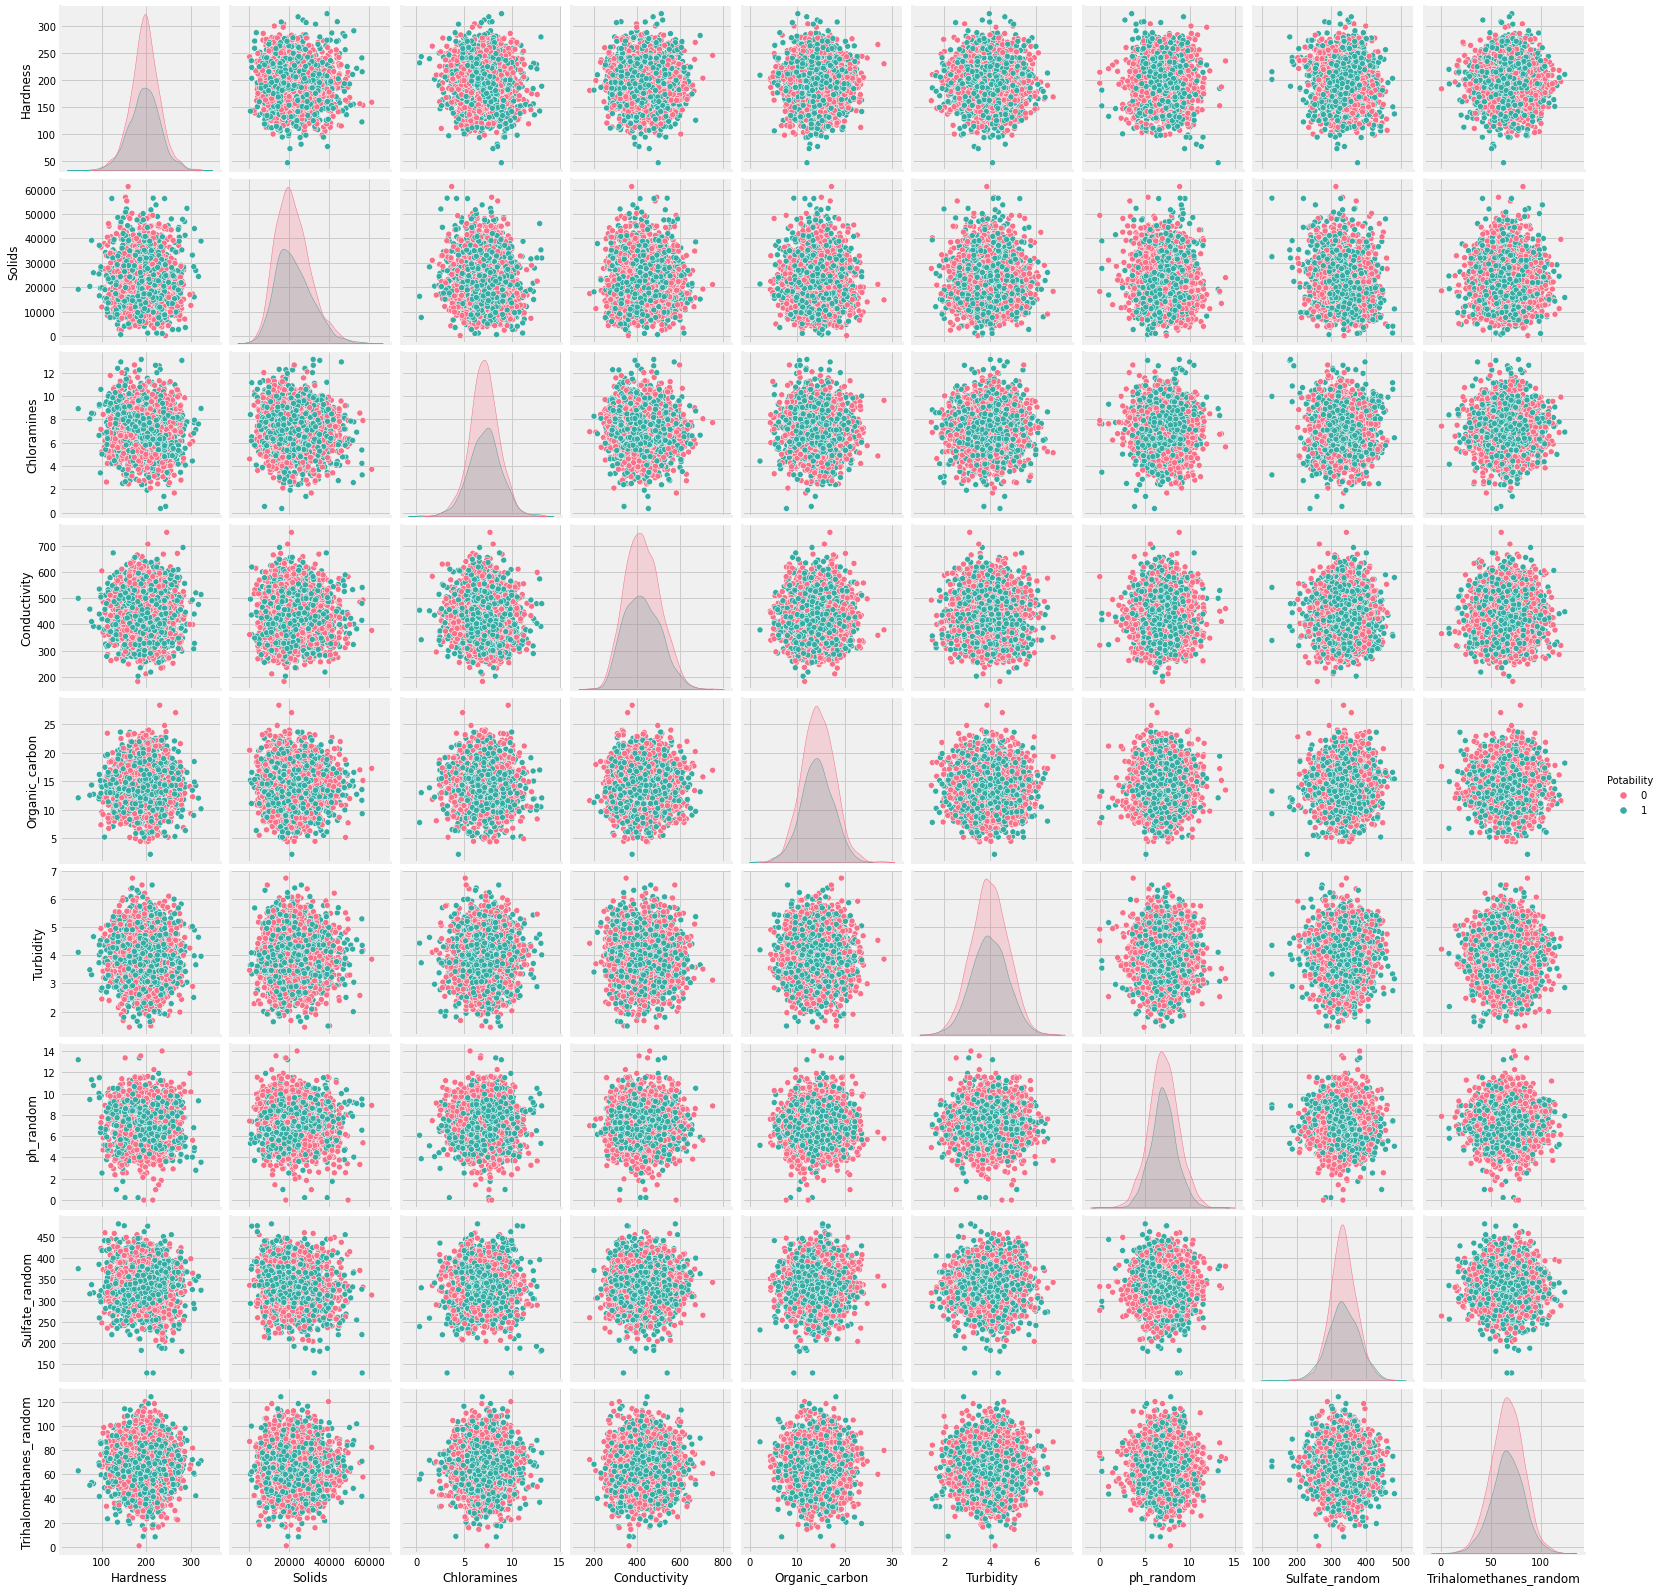

In [83]:
sns.pairplot(data, hue="Potability", palette="husl");

  0%|          | 0/9 [00:00<?, ?it/s]

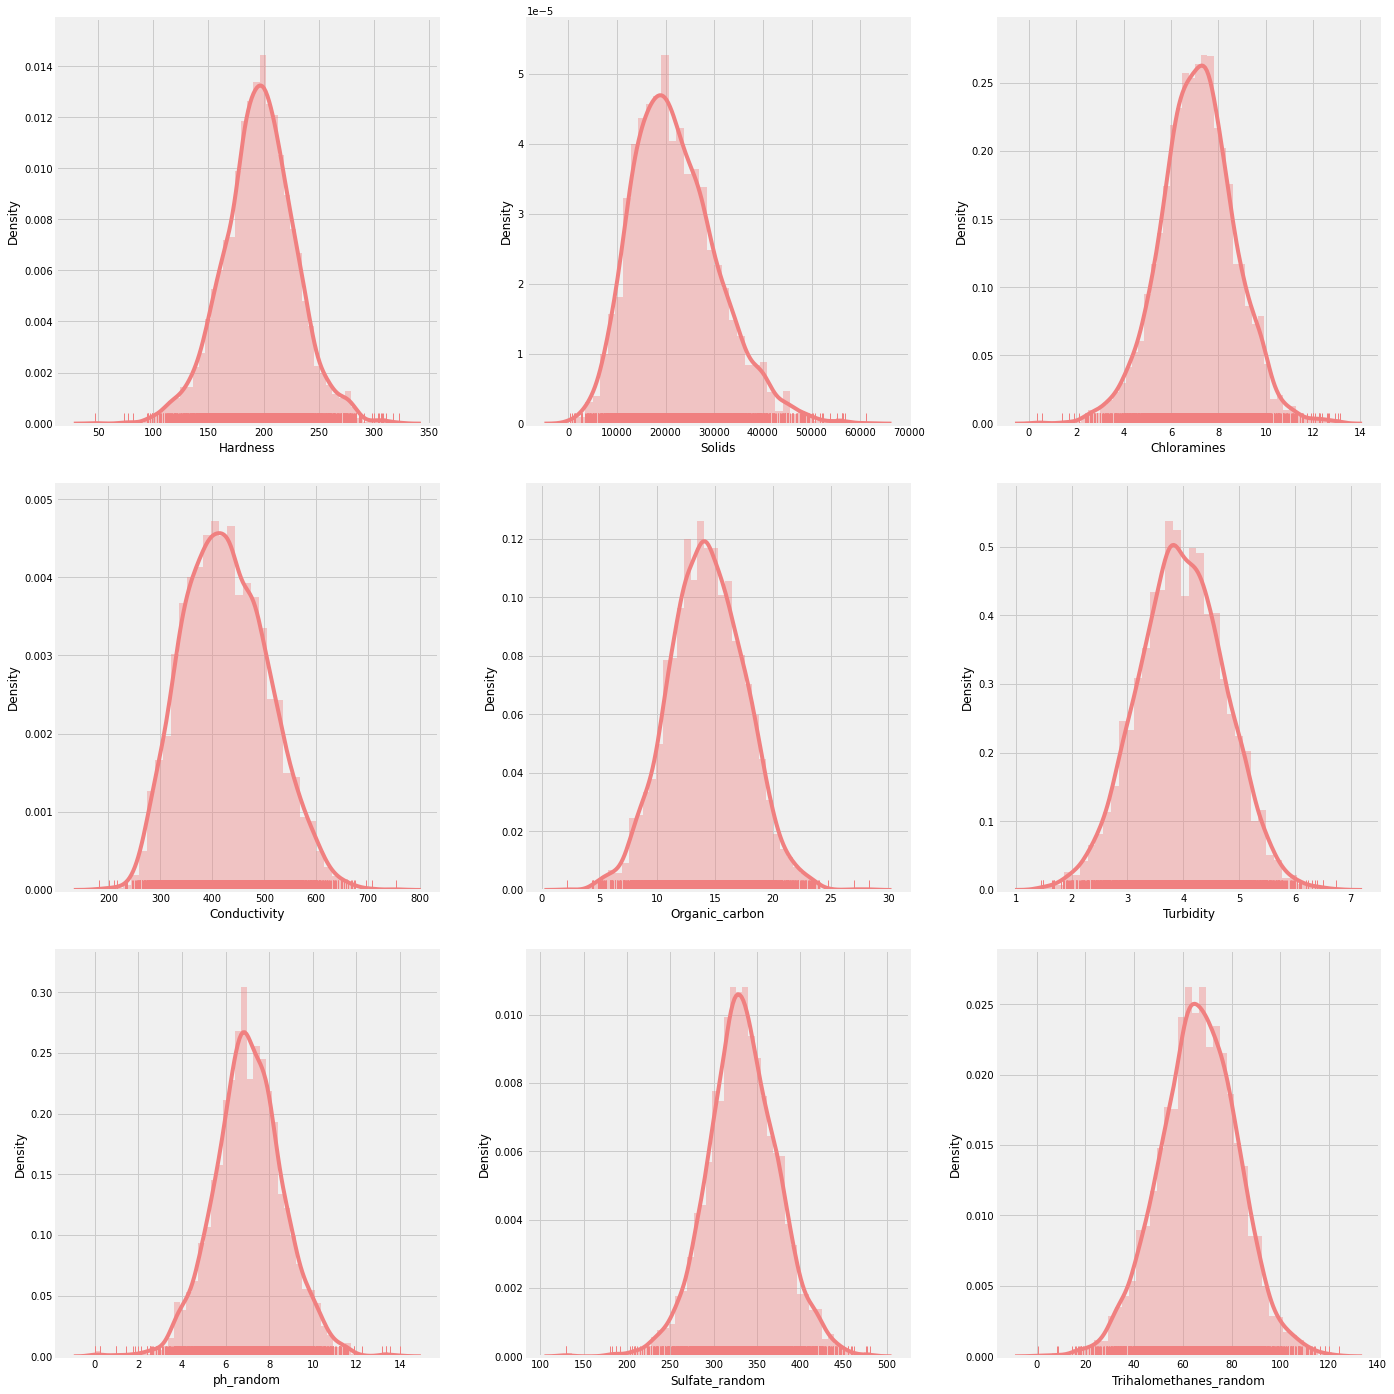

In [84]:
def distributionPlot(data):
    """ 
    Creates distribution plot.
    """
    fig = plt.figure(figsize=(20, 20))
    for i in tqdm_notebook(range(0, len(data.columns))):
        fig.add_subplot(np.ceil(len(data.columns)/3), 3, i+1)
        sns.distplot(
            data.iloc[:, i], color="lightcoral", rug=True)
        fig.tight_layout(pad=3.0)
plot_data = data.drop(['Potability'], axis =1)
distributionPlot(plot_data)

### Hardness

In [85]:
data['Hardness'].describe()

count    3276.000000
mean      196.369496
std        32.879761
min        47.432000
25%       176.850538
50%       196.967627
75%       216.667456
max       323.124000
Name: Hardness, dtype: float64

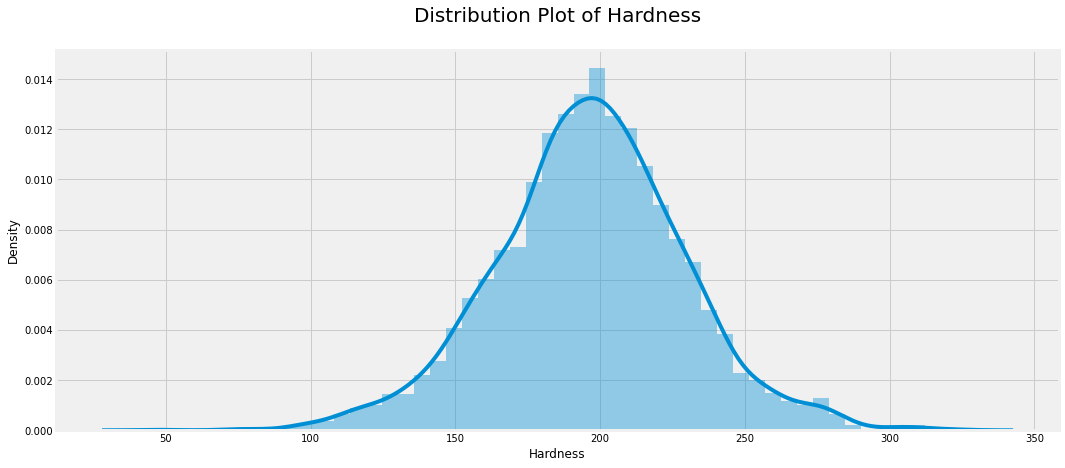

In [86]:
plt.figure(figsize = (16, 7))
sns.distplot(data['Hardness'])
plt.title('Distribution Plot of Hardness\n', fontsize =  20)
plt.show()

In [90]:
# basic scatter plot
fig = px.scatter(data,range(data['Hardness'].count()), sorted(data['Hardness']),
                 color=data['Potability'],
                 labels={
                     'x': "Count",
                     'y': "Hardness",
                     'color':'Potability'
                     
                 }, template = 'plotly')
fig.update_layout(title='Hardness wrt Potability')
fig.show()

In [91]:
px.histogram(data_frame = data, x = 'Hardness', nbins = 10, color = 'Potability', marginal = 'box',
             template = 'plotly')

### Solids

In [92]:
data['Solids'].describe()

count     3276.000000
mean     22014.092526
std       8768.570828
min        320.942611
25%      15666.690297
50%      20927.833607
75%      27332.762127
max      61227.196008
Name: Solids, dtype: float64

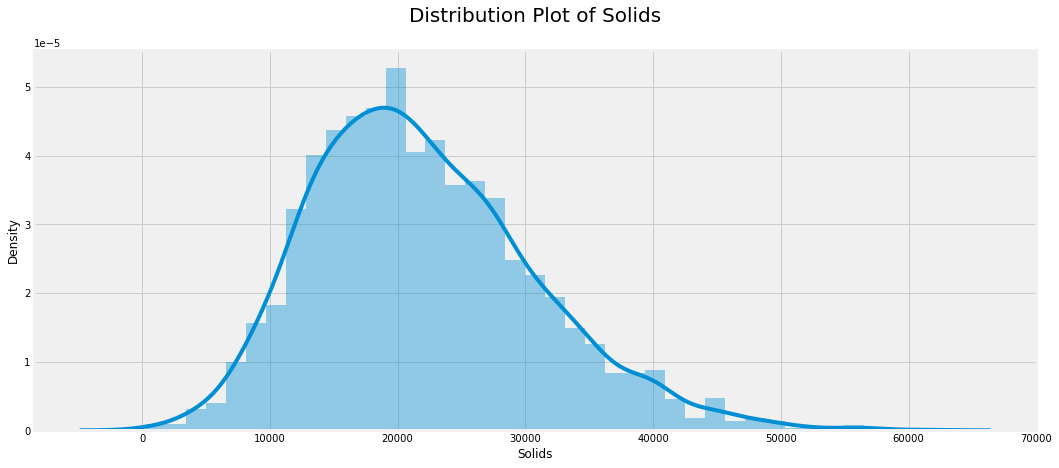

In [93]:
plt.figure(figsize = (16, 7))
sns.distplot(data['Solids'])
plt.title('Distribution Plot of Solids\n', fontsize =  20)
plt.show()

In [94]:
fig = px.scatter(data, sorted(data["Solids"]), range(data["Solids"].count()), color="Potability", facet_col="Potability", 
                 facet_row="Potability")
fig.show()

In [95]:
px.histogram(data_frame = data, x = 'Solids', nbins = 10, color = 'Potability', marginal = 'box',
             template = 'plotly')

In [96]:
# basic scatter plot
fig = px.scatter(data,range(data['Solids'].count()), sorted(data['Solids']),
                 color=data['Potability'],
                 labels={
                     'x': "Count",
                     'y': "Hardness",
                     'color':'Potability'
                     
                 },
                 color_continuous_scale=px.colors.sequential.tempo,
                 template = 'plotly')
fig.update_layout(title='Hardness wrt Potability')
fig.show()

### Chloramines

In [97]:
data['Chloramines'].describe()

count    3276.000000
mean        7.122277
std         1.583085
min         0.352000
25%         6.127421
50%         7.130299
75%         8.114887
max        13.127000
Name: Chloramines, dtype: float64

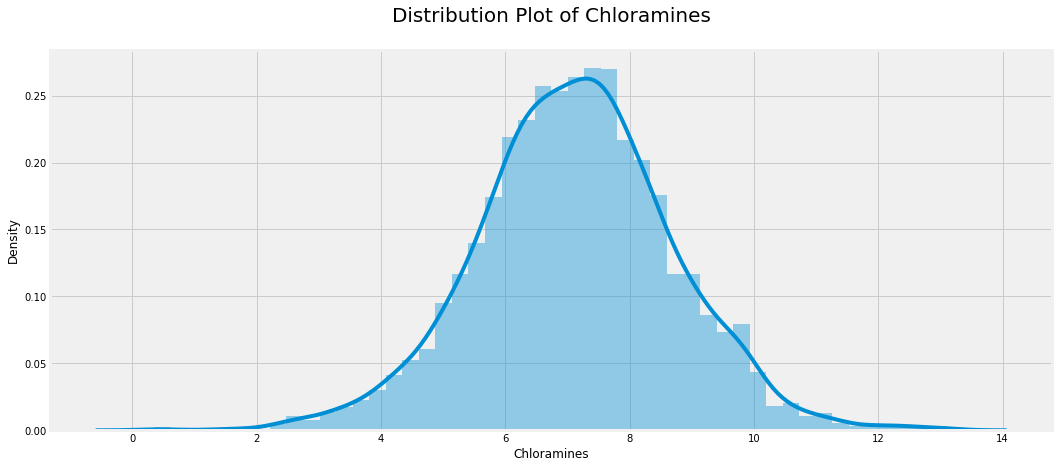

In [98]:
plt.figure(figsize = (16, 7))
sns.distplot(data['Chloramines'])
plt.title('Distribution Plot of Chloramines\n', fontsize =  20)
plt.show()

In [99]:
fig = px.line(x=range(data['Chloramines'].count()), y=sorted(data['Chloramines']),color=data['Potability'], labels={
                     'x': "Count",
                     'y': "Chloramines",
                     'color':'Potability'
                     
                 }, template = 'plotly')
fig.update_layout(title='Chloramines wrt Potability')
fig.show()

In [100]:
fig = px.box(x = 'Chloramines', data_frame = data, template = 'plotly')
fig.update_layout(title='Chloramines')
fig.show()

### Conductivity

In [101]:
data["Conductivity"].describe()

count    3276.000000
mean      426.205111
std        80.824064
min       181.483754
25%       365.734414
50%       421.884968
75%       481.792304
max       753.342620
Name: Conductivity, dtype: float64

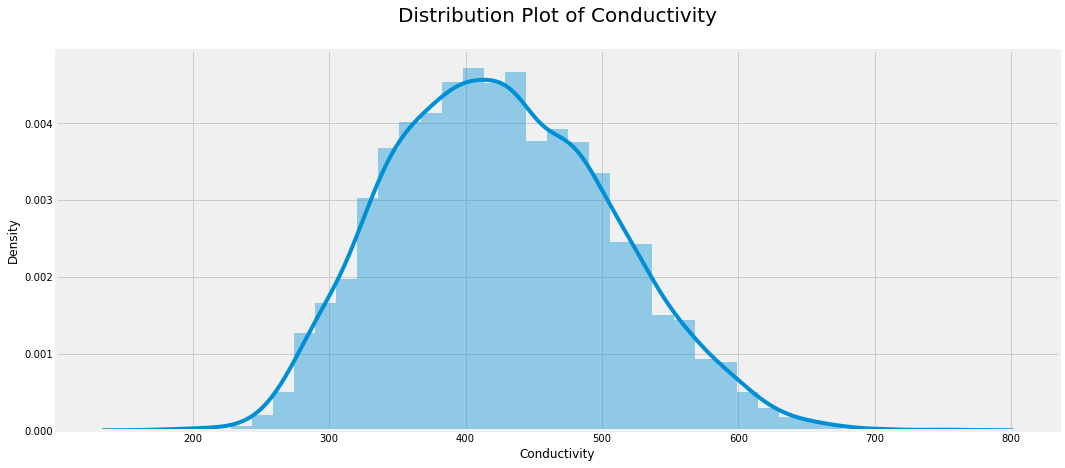

In [102]:
plt.figure(figsize = (16, 7))
sns.distplot(data['Conductivity'])
plt.title('Distribution Plot of Conductivity\n', fontsize =  20)
plt.show()

In [103]:
fig = px.bar(data, x=range(data['Conductivity'].count()),
             y=sorted(data['Conductivity']), labels={
                     'x': "Count",
                     'y': "Conductivity",
                     'color':'Potability'
                     
                 },
             color=data['Potability']
             ,template = 'plotly')
fig.update_layout(title='Conductivity wrt Potability')
fig.show() 

### Organic_carbon

In [104]:
data.describe()

Hardness        Solids  Chloramines  Conductivity  Organic_carbon  \
count  3276.000000   3276.000000  3276.000000   3276.000000     3276.000000   
mean    196.369496  22014.092526     7.122277    426.205111       14.284970   
std      32.879761   8768.570828     1.583085     80.824064        3.308162   
min      47.432000    320.942611     0.352000    181.483754        2.200000   
25%     176.850538  15666.690297     6.127421    365.734414       12.065801   
50%     196.967627  20927.833607     7.130299    421.884968       14.218338   
75%     216.667456  27332.762127     8.114887    481.792304       16.557652   
max     323.124000  61227.196008    13.127000    753.342620       28.300000   

         Turbidity   Potability    ph_random  Sulfate_random  \
count  3276.000000  3276.000000  3276.000000     3276.000000   
mean      3.966786     0.390110     7.071639      333.430954   
std       0.780382     0.487849     1.607991       41.026947   
min       1.450000     0.000000     0.000000      129.000000   
25%       3.439711     0.000000     6.081460      307.523159   
50%       3.955028     0.000000     7.029490      332.879578   
75%       4.500320     1.000000     8.063147      359.710517   
max       6.739000     1.000000    14.000000      481.030642   

       Trihalomethanes_random  
count             3276.000000  
mean                66.419200  
std                 16.184832  
min                  0.738000  
25%                 55.861675  
50%                 66.639068  
75%                 77.384166  
max                124.000000

In [105]:
group_labels = ['Organic_carbon'] # name of the dataset

fig = ff.create_distplot([data['Organic_carbon']], group_labels)
fig.show()

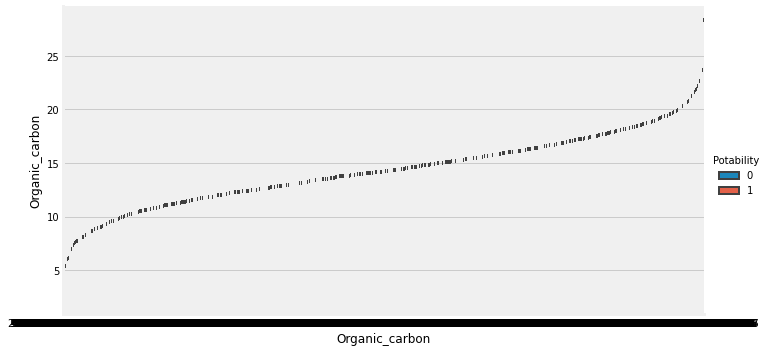

In [106]:
sns.catplot(x = 'Organic_carbon', y = 'Organic_carbon', hue = 'Potability', data = data, kind = 'box',
            height = 5, aspect = 2)
plt.show()

### Turbidity

In [108]:
data['Turbidity'].describe()

count    3276.000000
mean        3.966786
std         0.780382
min         1.450000
25%         3.439711
50%         3.955028
75%         4.500320
max         6.739000
Name: Turbidity, dtype: float64

In [109]:
group_labels = ['Turbidity'] # name of the dataset

fig = ff.create_distplot([data['Turbidity']], group_labels)
fig.show()

In [110]:
data['turbid_class']=data['Turbidity'].astype(int)

In [111]:
data['turbid_class'].unique()

array([2, 4, 3, 5, 6, 1])

In [113]:
px.scatter(data_frame = data, x = 'Turbidity', y = 'turbid_class', color = 'Potability', template = 'plotly')

In [115]:
fig = px.pie(data,
             values=data['turbid_class'].value_counts(), 
             names=data['turbid_class'].value_counts().keys(),
            )
fig.update_layout(
    title='turbid_class',
    template = 'plotly'
)
fig.show()

In [116]:
data=data.drop(['turbid_class'],axis=1)

# ph_random

In [117]:
data['ph_random'].describe()

count    3276.000000
mean        7.071639
std         1.607991
min         0.000000
25%         6.081460
50%         7.029490
75%         8.063147
max        14.000000
Name: ph_random, dtype: float64

In [118]:
group_labels = ['ph_random'] # name of the dataset

fig = ff.create_distplot([data['ph_random']], group_labels)
fig.show()

In [119]:
px.histogram(data_frame = data, x = 'ph_random', nbins = 10, color = 'Potability', marginal = 'box',
             template = 'plotly')

In [120]:
fig = px.scatter(data, sorted(data["ph_random"]), range(data["ph_random"].count()), color="Potability", facet_col="Potability", 
                 facet_row="Potability")
fig.show()

# Potability

In [121]:
data['Potability'].describe()

count    3276.000000
mean        0.390110
std         0.487849
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Potability, dtype: float64

In [122]:
px.histogram(data_frame = data, x = 'Potability', color = 'Potability', marginal = 'box',
             template = 'plotly')

In [123]:
fig = px.pie(data,
             values=data['Potability'].value_counts(), 
             names=data['Potability'].value_counts().keys(),
            )
fig.update_layout(
    title='Potability',
    template = 'plotly'
)
fig.show()

# Data Preprocessing

In [124]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [125]:
X=data.drop(['Potability'],axis=1)
y=data['Potability']

Since the data is not in a uniform shape, we scale the data using standard scalar

In [126]:
scaler = StandardScaler()
x=scaler.fit_transform(X)

In [127]:
# split the data to train and test set
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.85,random_state=42)


print("training data shape:-{} labels{} ".format(x_train.shape,y_train.shape))
print("testing data shape:-{} labels{} ".format(x_test.shape,y_test.shape))

training data shape:-(2784, 9) labels(2784,) 
testing data shape:-(492, 9) labels(492,) 


# Modeling

### Logistic Regression

In [128]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(random_state=0).fit(x_train, y_train)
log.score(x_test, y_test)

0.6219512195121951

No handles with labels found to put in legend.


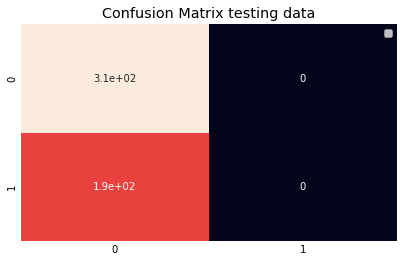

In [129]:
#  Confusion matrix
from sklearn.metrics import confusion_matrix
# Make Predictions
pred1=log.predict(np.array(x_test))
plt.title("Confusion Matrix testing data")
sns.heatmap(confusion_matrix(y_test,pred1),annot=True,cbar=False)
plt.legend()
plt.show()

### K Nearest Neighbours

In [130]:
from sklearn.neighbors import KNeighborsClassifier

In [131]:
knn = KNeighborsClassifier(n_neighbors=2)
# Train the model using the training sets
knn.fit(x_train,y_train)

#Predict Output
predicted= knn.predict(x_test) # 0:Overcast, 2:Mild



No handles with labels found to put in legend.


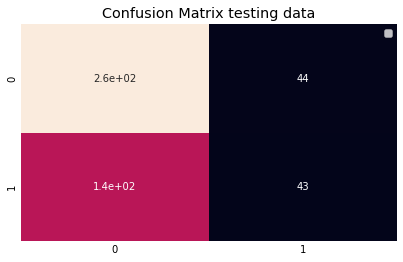

In [132]:
#  Confusion matrix
from sklearn.metrics import confusion_matrix
# Make Predictions
pred1=knn.predict(np.array(x_test))
plt.title("Confusion Matrix testing data")
sns.heatmap(confusion_matrix(y_test,pred1),annot=True,cbar=False)
plt.legend()
plt.show()

### Decision Tree

In [133]:
from sklearn import tree
from sklearn.metrics import accuracy_score

In [134]:
tre = tree.DecisionTreeClassifier()
tre = tre.fit(x_train, y_train)

y_pred = tre.predict(x_test)
print(accuracy_score(y_test,y_pred))

0.5447154471544715


No handles with labels found to put in legend.


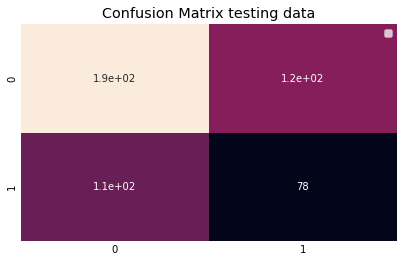

In [135]:
#  Confusion matrix
from sklearn.metrics import confusion_matrix
# Make Predictions
pred1=tre.predict(np.array(x_test))
plt.title("Confusion Matrix testing data")
sns.heatmap(confusion_matrix(y_test,pred1),annot=True,cbar=False)
plt.legend()
plt.show()

### Random Forest

In [136]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [137]:
# create the model
model_rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=100)


# fitting the model
model_rf=model_rf.fit(x_train, y_train) 

y_pred = model_rf.predict(x_test)
print(accuracy_score(y_test,y_pred))

0.6788617886178862


No handles with labels found to put in legend.


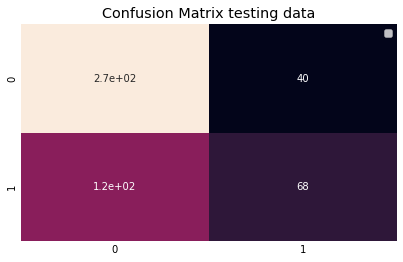

In [138]:
#  Confusion matrix
from sklearn.metrics import confusion_matrix
# Make Predictions
pred1=model_rf.predict(np.array(x_test))
plt.title("Confusion Matrix testing data")
sns.heatmap(confusion_matrix(y_test,pred1),annot=True,cbar=False)
plt.legend()
plt.show()